In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2 as cv
from osgeo import gdal
import netCDF4
import tqdm
import json
from scipy.spatial import ckdtree
plt.ion()
import scipy.io as io
import shutil
import requests

In [2]:
# under WGS84 Assumption
# "a"
semiMajor = 6.378137000000000e+06
# "b"
semiMinor = 6.356752314245179e+06
# "Rnear"
slant = 8.436862401575363e+05
groundOrigin = 0

In [3]:
land_mask = io.loadmat('landmaskna.mat')
land_mask_val = land_mask['landnafp']
land_mask_flat_lat = land_mask['latvalsna'].flatten()
land_mask_flat_lon = land_mask['lonvalsna'].flatten()
# land_mask_xyz = np.zeros([len(land_mask_flat_lat)*len(land_mask_flat_lon), 3])
# count = 0
# for lon in tqdm.tqdm(land_mask_flat_lon):
#     for lat in land_mask_flat_lat:
#         land_mask_xyz[count] = cart_transform(lat, lon)
#         count = count + 1
        
land_lat_fit = np.poly1d(np.polyfit(land_mask_flat_lat,range(0, len(land_mask_flat_lat)), 1))
land_lon_fit = np.poly1d(np.polyfit(land_mask_flat_lon, range(0, len(land_mask_flat_lon)), 1))

In [89]:
len(land_mask_flat_lat)

3000

In [4]:
folder_json_path = 'training_data/charted_folders.json'
with open(folder_json_path) as fp:
    folder_data = json.load(fp)['folders']

In [76]:
t_file = os.listdir(os.path.join('training_data', '20110730'))[-1]

In [77]:
t_file = os.path.join('training_data', '20110730', t_file)

In [56]:
t_file

'training_data\\20100405\\RS2_OK10889_PK125552_DK119730_SCWA_20100405_161248.tif'

In [57]:
data = gdal.Open(t_file, gdal.GA_ReadOnly)

In [58]:
img_shape = [data.RasterXSize, data.RasterYSize]

In [9]:
img_shape

NameError: name 'img_shape' is not defined

In [4]:
def cart_transform(phi, lam):
    phi_rad = np.pi * phi/180
    lam_rad = np.pi * lam/180
    den = np.sqrt(semiMajor*semiMajor*np.cos(phi_rad)*np.cos(phi_rad) + semiMinor*semiMinor*np.sin(phi_rad)*np.sin(phi_rad))    
    Xuv = (semiMajor*semiMajor * np.cos(phi_rad) * np.cos(lam_rad))/den
    Yuv = (semiMajor*semiMajor * np.cos(phi_rad) * np.sin(lam_rad))/den
    Zuv = (semiMinor*semiMinor*np.sin(phi_rad))/den
    return (Xuv, Yuv, Zuv)

def cart_inv(x,y,z):
    phi_rad = np.arctan(semiMajor*z/(semiMinor*np.sqrt(semiMinor*semiMinor - z*z)))
    lam_rad = np.arctan2(y,x)
    phi = 180*phi_rad/(np.pi)
    lam = 180*lam_rad/(np.pi)
    return phi, lam

In [5]:
def idw(distances):
    if np.count_nonzero(distances) != len(distances):
        weights = np.zeros_like(distances)
        weights[0] = 1
    else:
        inverse_sum = sum([1/d for d in distances])
        weights = (1/distances)/inverse_sum
    return weights

In [6]:
def concentration(tree, lat, lon,chart_data_flat, samples=16):
    '''
    Given a lat-lon pair interpolate using IDW to find the actual concentration
    '''
#     land_pos_y = int(np.round(land_lon_fit(lon-360)))
#     land_pos_x = int(np.round(land_lat_fit(lat)))
    
#     land_val = land_mask_val[land_pos_x,land_pos_y]
    
#     if not np.isnan(land_val):
#         return 255
    dists, idxs = tree.query((lat, lon), samples)
    concentration_values = np.array([chart_data_flat[i] for i in idxs])
    nan_vals = np.isnan(concentration_values)
    if any(nan_vals):
        return np.nan
    try:
        weights = idw(dists)
    except:
        weights = 1
        return chart_data_flat[idxs]
    return np.sum(np.multiply(concentration_values, weights))

In [7]:
def concentration_Z(tree, x, y,z,chart_data_flat, samples=16):
    '''
    Given a lat-lon pair interpolate using IDW to find the actual concentration
    '''
#     land_pos_y = int(np.round(land_lon_fit(lon-360)))
#     land_pos_x = int(np.round(land_lat_fit(lat)))
    
#     land_val = land_mask_val[land_pos_x,land_pos_y]
    
#     if not np.isnan(land_val):
#         return 255
    dists, idxs = tree.query((x, y,z), samples)
    concentration_values = np.array([chart_data_flat[i] for i in idxs])
    nan_vals = np.isnan(concentration_values)
    if any(nan_vals):
        return 255
    try:
        weights = idw(dists)
    except:
        weights = 1
        return chart_data_flat[idxs]
    return np.sum(np.multiply(concentration_values, weights))

In [125]:
t_file

'training_data\\20090322\\RS2_OK4491_PK59492_DK57897_SCWA_20090322_102729_HH.tif'

In [8]:
folders = glob.glob(os.path.join('training_data', '20*'))

In [9]:
folder

NameError: name 'folder' is not defined

In [12]:

grid = netCDF4.Dataset(grid_file)

latdata = np.asarray(grid.variables['Latitudes'])
londata = np.asarray(grid.variables['Longitudes'])
grid_lat_flat = np.asarray(latdata).flatten()
grid_lon_flat = np.asarray(londata).flatten()
grid_flat = np.stack([grid_lat_flat, grid_lon_flat], 1)
XYZ_flat = np.zeros([grid_flat.shape[0], 3])
for i,g in tqdm.tqdm(enumerate(grid_flat)):
    if g[1] > 180:
        g[1] = g[1] - 360
    XYZ_flat[i] = cart_transform(g[0],g[1])
XYZ_flat = np.asarray([cart_transform(g[0],g[1]) for g in grid_flat])
print('XYZ TREE')
XYZ_tree = ckdtree.cKDTree(XYZ_flat)
chart_tree = ckdtree.cKDTree(grid_flat)

2179072it [00:53, 40466.12it/s]


XYZ TREE


In [17]:
index = folders.index(folder)

In [18]:
index

31

In [20]:
i

32

In [25]:
folder


'training_data\\20110903D'

In [21]:
for i, folder in enumerate(tqdm.tqdm(folders)):
    if i > index:
        chart_file = glob.glob(os.path.join(folder, 'asi-*.nc'))[0]
        geotiff_file = sorted(glob.glob(os.path.join(folder, '*.tif')), key=os.path.getsize)[-1]
        res = gen_conc_image(chart_file, XYZ_tree, chart_tree, geotiff_file)
        cv.imwrite(os.path.join(folder, 'conc.tiff'), res[1])
    #     break

  0%|                                                                                           | 0/38 [00:00<?, ?it/s]

[632, 661]


c:\users\clvco\anaconda3\lib\site-packages\numpy\core\numeric.py:531: RuntimeWarning: invalid value encountered in less
  return array(a, dtype, copy=False, order=order)
c:\users\clvco\anaconda3\lib\site-packages\numpy\core\numeric.py:531: RuntimeWarning: invalid value encountered in greater
  return array(a, dtype, copy=False, order=order)
 87%|███████████████████████████████████████████████████████████████████████▏          | 33/38 [01:50<00:16,  3.34s/it]

[373, 659]


 89%|█████████████████████████████████████████████████████████████████████████▎        | 34/38 [03:04<00:21,  5.41s/it]

[632, 657]


 92%|███████████████████████████████████████████████████████████████████████████▌      | 35/38 [05:10<00:26,  8.87s/it]

[631, 658]


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 36/38 [07:18<00:24, 12.18s/it]

[627, 658]


 97%|███████████████████████████████████████████████████████████████████████████████▊  | 37/38 [09:19<00:15, 15.13s/it]

[632, 661]


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [11:20<00:00, 17.91s/it]


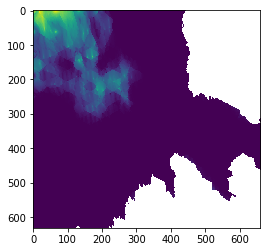

In [23]:
plt.imshow(res[0])

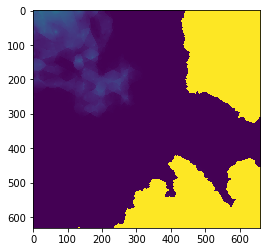

In [24]:
plt.imshow(res[1])

In [9]:
chart_file

'training_data\\20090322\\asi-n6250-20090322-v5.nc'

In [10]:
geotiff_file

'training_data\\20090322\\RS2_OK4491_PK59492_DK57897_SCWA_20090322_102729_HH.tif'

In [11]:
chart_file = r"C:\Users\clvco\URA_W18\training_data\20110730\asi-n6250-20110730-v5.nc"
grid_file = r"C:\Users\clvco\URA_W18\training_data\20110730\LongitudeLatitudeGrid-n6250-Arctic.nc"

In [79]:
SAR_image = r"C:\Users\clvco\URA_W18\training_data\20110730\imagery_HH.tif"

In [61]:
sar = cv.imread(SAR_image)

[158, 165]


c:\users\clvco\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1350: RuntimeWarning: invalid value encountered in less
  x = np.array(x, subok=True, copy=copy)
c:\users\clvco\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1350: RuntimeWarning: invalid value encountered in greater
  x = np.array(x, subok=True, copy=copy)
2179072it [01:10, 31068.98it/s]


XYZ TREE


c:\users\clvco\anaconda3\lib\site-packages\numpy\core\numeric.py:531: RuntimeWarning: invalid value encountered in less
  return array(a, dtype, copy=False, order=order)
c:\users\clvco\anaconda3\lib\site-packages\numpy\core\numeric.py:531: RuntimeWarning: invalid value encountered in greater
  return array(a, dtype, copy=False, order=order)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:08<00:00, 18.16it/s]


Max lat:  75.7275141704
Min lat:  70.4573715082
Max lon:  -98.3650747317
Min lon:  -116.80402047


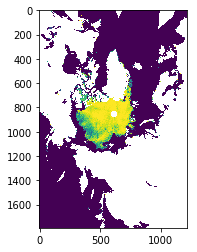

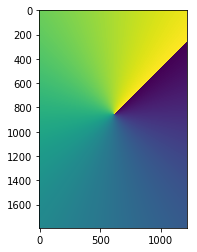

In [80]:
res = gen_conc_image(chart_file, grid_file, t_file)

In [14]:
# FIX THE GRID FILE, THERE IS SOMETHING WRONG WITH THE LON NUMBERS I BELIEVE
def gen_conc_image(chart_path, XYZ_tree, chart_tree, geotiff_path, DOWN_RATE=16):
    dataset = gdal.Open(geotiff_path, gdal.GA_ReadOnly)

    image_shape = [np.round(dataset.RasterYSize/DOWN_RATE).astype(np.int), np.round(dataset.RasterXSize/DOWN_RATE).astype(np.int)]
    print(image_shape)
    chart = netCDF4.Dataset(chart_path)
#     plt.figure()
#     plt.imshow(chart['ASI_Ice_Concentration'])
#     grid = netCDF4.Dataset(grid_path)
    
#     latdata = np.asarray(grid.variables['Latitudes'])
#     londata = np.asarray(grid.variables['Longitudes'])
#     plt.figure()
#     plt.imshow(londata)
#     return None
    
#     grid_lat_flat = np.asarray(latdata).flatten()
#     grid_lon_flat = np.asarray(londata).flatten()
#     grid_flat = np.stack([grid_lat_flat, grid_lon_flat], 1)
#     XYZ_flat = np.zeros([grid_flat.shape[0], 3])
#     for i,g in tqdm.tqdm(enumerate(grid_flat)):
#         if g[1] > 180:
#             g[1] = g[1] - 360
#         XYZ_flat[i] = cart_transform(g[0],g[1])
#     XYZ_flat = np.asarray([cart_transform(g[0],g[1]) for g in grid_flat])
#     return XYZ_flat
#     print('XYZ TREE')
#     XYZ_tree = ckdtree.cKDTree(XYZ_flat)
#     print('Normal TREE')
#     chart_tree = ckdtree.cKDTree(grid_flat)
    chart_data_flat = np.asarray(chart['ASI_Ice_Concentration']).flatten()
    
    control_pts = dataset.GetGCPs()
    control_pixel_locations = [(pt.GCPLine/DOWN_RATE, pt.GCPPixel/DOWN_RATE) for pt in control_pts]
    control_tree = ckdtree.cKDTree(control_pixel_locations)
    
    SAMPLES = 16
    pos_values = [cart_transform(pt.GCPY, pt.GCPX) for pt in control_pts]
    concentration_image = np.zeros((image_shape))
    concentration_z_image = np.zeros((image_shape))
    lats = []
    lons = []
    for i in (range(concentration_image.shape[0])):
        for j in range(concentration_image.shape[1]):
            #TODO:  put in max dist for speed
            distances, indices = control_tree.query((i, j), SAMPLES)
            weights = idw(distances)
            X_values = [pos_values[index][0] for index in indices]
            Y_values = [pos_values[index][1] for index in indices]
            Z_values = [pos_values[index][2] for index in indices]
            X = np.sum(np.multiply(X_values, weights))
            Y = np.sum(np.multiply(Y_values, weights))
            Z = np.sum(np.multiply(Z_values, weights))
            conc_Z = concentration_Z(XYZ_tree, X,Y,Z, chart_data_flat)
            lat, lon = cart_inv(X,Y,Z)
            lats.append(lat)
            lons.append(lon)
            conc = concentration(chart_tree, lat, lon, chart_data_flat)
            concentration_image[i, j] = conc
            concentration_z_image[i,j] = conc_Z
#     print('Max lat: ', sorted(lats)[-1])
#     print('Min lat: ', sorted(lats)[0])
#     print('Max lon: ', sorted(lons)[-1])
#     print('Min lon: ', sorted(lons)[0])
    
    return concentration_image, concentration_z_image